In [ ]:
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 /content/kaggle.json

In [ ]:
# !kaggle datasets download -d ronanhansel/librisevoc-1k -p /content/LibriSeVoc --unzip

Dataset URL: https://www.kaggle.com/datasets/ronanhansel/librisevoc-1k
License(s): apache-2.0
 99% 3.15G/3.17G [00:34<00:00, 243MB/s]
100% 3.17G/3.17G [00:34<00:00, 97.7MB/s]


In [ ]:
import os
import shutil
import random
from tqdm import tqdm

def train_test_split_dataset(root_dir, split_ratio=0.8, seed=42):
    random.seed(seed)

    for class_folder in os.listdir(root_dir):
        class_path = os.path.join(root_dir, class_folder)
        if not os.path.isdir(class_path):
            continue

        print(f"Processing: {class_folder}")
        files = [f for f in os.listdir(class_path) if f.endswith(".wav")]
        random.shuffle(files)

        split_idx = int(len(files) * split_ratio)
        train_files = files[:split_idx]
        test_files = files[split_idx:]

        train_dir = os.path.join(class_path, "train")
        test_dir = os.path.join(class_path, "test")
        os.makedirs(train_dir, exist_ok=True)
        os.makedirs(test_dir, exist_ok=True)

        for f in tqdm(train_files, desc="Moving to train"):
            shutil.move(os.path.join(class_path, f), os.path.join(train_dir, f))

        for f in tqdm(test_files, desc="Moving to test"):
            shutil.move(os.path.join(class_path, f), os.path.join(test_dir, f))

    print("✅ Train-test split completed.")

train_test_split_dataset("/content/LibriSeVoc/LibriSeVoc-1k", split_ratio=0.8)


Processing: wavernn


Moving to test: 100%|██████████| 200/200 [00:00<00:00, 16346.33it/s]


Processing: gt


Moving to test: 100%|██████████| 200/200 [00:00<00:00, 22216.77it/s]


Processing: wavegrad


Moving to test: 100%|██████████| 200/200 [00:00<00:00, 15985.91it/s]


Processing: wavenet


Moving to test: 100%|██████████| 200/200 [00:00<00:00, 21347.23it/s]


Processing: melgan


Moving to test: 100%|██████████| 200/200 [00:00<00:00, 18853.35it/s]


Processing: parallel_wave_gan


Moving to test: 100%|██████████| 200/200 [00:00<00:00, 34477.04it/s]


Processing: diffwave


Moving to test: 100%|██████████| 200/200 [00:00<00:00, 28337.02it/s]

✅ Train-test split completed.


In [ ]:
DATA_PATH = '/content/LibriSeVoc/LibriSeVoc-1k'

class_dict = {
    'gt': 0,
    'wavenet': 1,
    'wavernn': 1,
    'melgan': 1,
    'parallel_wave_gan': 1,
    'diffwave': 1,
    'wavegrad': 1
}


num_classes = len(class_dict)

# FEATURE EXTRACTOR

In [ ]:
import numpy as np
import librosa
import os
import soundfile as sf
from sklearn.preprocessing import normalize
import os
import pandas as pd
import random
from tqdm import tqdm
import torchaudio
import torch
from torch.utils.data import Dataset


In [ ]:
frame_length=0.025
frame_shift=0.010
sample_rate=24000
n_lfcc=20

def pre_emphasis(signal, coeff=0.97):
    return np.append(signal[0], signal[1:] - coeff * signal[:-1])

def peak_normalize(signal):
    return signal / np.max(np.abs(signal))

def add_noise(signal, noise_level=0.005):
    noise = np.random.normal(0, noise_level, signal.shape)
    return signal + noise

def chunk_signal(signal, sr, frame_length=frame_length, frame_shift=frame_shift):
    frame_len = int(frame_length * sr)
    hop_len = int(frame_shift * sr)
    frames = librosa.util.frame(signal, frame_length=frame_len, hop_length=hop_len).T
    return frames

lfcc_transform = torchaudio.transforms.LFCC(
    sample_rate=sample_rate,
    n_lfcc=n_lfcc,
    speckwargs={"n_fft": 1048, "hop_length": int(sample_rate * frame_length) + 1, "win_length": int(sample_rate * frame_length)},
    log_lf=True
)

def extract_lfcc(frame, sr = 24000):
    waveform = torch.tensor(frame).float().unsqueeze(0)
    lfcc = lfcc_transform(waveform)
    return lfcc.squeeze(0).T.numpy()


In [ ]:
import numpy as np
import os
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from tqdm import tqdm

import joblib
from scipy.stats import skew, kurtosis

In [ ]:
GMMs = {
    "groundtruth": joblib.load("/content/drive/MyDrive/IntroAIProject/model/gmm_model_ground-truth.pkl"),
    "autoregressive": joblib.load("/content/drive/MyDrive/IntroAIProject/model/gmm_model_autoregressive.pkl"),
    "gan-based": joblib.load("/content/drive/MyDrive/IntroAIProject/model/gmm_model_gan-based.pkl"),
    "diffusion-based": joblib.load("/content/drive/MyDrive/IntroAIProject/model/gmm_model_diffusion-based.pkl"),
}

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator GaussianMixture from version 1.2.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [ ]:
def extract_gmm_scores(file_path, gmms, sr=24000):
    import librosa

    y, sr = librosa.load(file_path, sr=sr)
    y = peak_normalize(pre_emphasis(y))
    y = add_noise(y, noise_level=0.005)
    frames = chunk_signal(y, sr)

    gmm_scores = {}
    for gmm_name in GMMs.keys():
        gmm_scores[gmm_name] = []

    for frame in frames:
        if np.any(frame):
            for gmm_name, gmm in gmms.items():
                lfcc = extract_lfcc(frame, sr)
                logL = gmm.score_samples(lfcc)
                gmm_scores[gmm_name].append(logL)
    feature = []
    for gmm_name in GMMs.keys():
        scores = gmm_scores[gmm_name]
        feature.extend([
            np.mean(scores),
            np.std(scores),
            skew(scores)[0],
            kurtosis(scores)[0],
            np.min(scores),
            np.max(scores),
            np.percentile(scores, 25),
            np.percentile(scores, 75)
        ])

    return np.array(feature)

# DATALOADER

In [ ]:
class VoiceDataset(Dataset):
    def __init__(self, file_list, sample_rate=16000, mode='train', mel_transform=None):
        self.file_list = file_list
        self.sample_rate = sample_rate
        self.mode = mode
        self.mel_transform = mel_transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        path, label = self.file_list[idx]
        return extract_gmm_scores(path, GMMs), torch.tensor(label, dtype=torch.float32)


In [ ]:
def get_datasets(root_dir, fake_folders, sample_rate=16000):
    train_list_fake = []
    train_list_real = []
    test_list_fake = []
    test_list_real = []

    test_size = 200
    train_size = 800

    for folder in ['gt'] + fake_folders:
        for split in ['train', 'test']:
            path = os.path.join(root_dir, folder, split)
            label = class_dict[folder]
            for file in os.listdir(path):
                if file.endswith(".wav"):
                    full_path = os.path.join(path, file)
                    if split == 'train':
                        if label == 1:
                            train_list_fake.append((full_path, label))
                        else:
                            train_list_real.append((full_path, label))
                    else:
                        if label == 1:
                            test_list_fake.append((full_path, label))
                        else:
                            test_list_real.append((full_path, label))

    mel_transform = torchaudio.transforms.MelSpectrogram(
        sample_rate=sample_rate,
        n_fft=2048,
        hop_length=512,
        n_mels=128
    )

    random.shuffle(train_list_fake)
    random.shuffle(test_list_fake)
    train_dataset = VoiceDataset(train_list_fake[:train_size] + train_list_real[:train_size], sample_rate=sample_rate, mode='train', mel_transform=mel_transform)
    test_dataset = VoiceDataset(test_list_fake[:test_size] + test_list_real[:test_size], sample_rate=sample_rate, mode='test', mel_transform=mel_transform)

    return train_dataset, test_dataset


In [ ]:
import numpy as np
from torch.utils.data import DataLoader
import os
import torch

fake_folders = [folder for folder, label in class_dict.items() if label == 1]

train_dataset, test_dataset = get_datasets(DATA_PATH, fake_folders, sample_rate=24000)

# Create DataLoaders (batch size 1 to get individual features and labels)
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Extract features and labels from DataLoaders
train_features = []
train_labels = []
for features, labels in tqdm(train_dataloader, desc="Processing train data"):
    train_features.append(features.squeeze().numpy())
    train_labels.append(labels.squeeze().numpy())

test_features = []
test_labels = []
for features, labels in tqdm(test_dataloader, desc="Processing test data"):
    test_features.append(features.squeeze().numpy())
    test_labels.append(labels.squeeze().numpy())

# Convert lists to numpy arrays
train_features = np.array(train_features)
train_labels = np.array(train_labels)
test_features = np.array(test_features)
test_labels = np.array(test_labels)

# Define the directory to save the files
save_dir = '/content/drive/MyDrive/IntroAIProject/smallsize_test'
os.makedirs(save_dir, exist_ok=True)

# Save the feature and label arrays
np.save(os.path.join(save_dir, 'train_features.npy'), train_features)
np.save(os.path.join(save_dir, 'train_labels.npy'), train_labels)
np.save(os.path.join(save_dir, 'test_features.npy'), test_features)
np.save(os.path.join(save_dir, 'test_labels.npy'), test_labels)

print(f"Train features and labels saved to {os.path.join(save_dir, 'train  _features.npy')} and {os.path.join(save_dir, 'train_labels.npy')}")
print(f"Test features and labels saved to {os.path.join(save_dir, 'test_features.npy')} and {os.path.join(save_dir, 'test_labels.npy')}")


Processing test data: 100%|██████████| 400/400 [28:05<00:00,  4.21s/it]

Train features and labels saved to /content/drive/MyDrive/IntroAIProject/smallsize_test/train_features.npy and /content/drive/MyDrive/IntroAIProject/smallsize_test/train_labels.npy
Test features and labels saved to /content/drive/MyDrive/IntroAIProject/smallsize_test/test_features.npy and /content/drive/MyDrive/IntroAIProject/smallsize_test/test_labels.npy


# CLASSIFIER

Loaded train and test data for classification.
Train data shape: (1600, 32), (1600,)
Test data shape: (400, 32), (400,)
Training XGBoost classifier...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:25:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


✅ XGBoost classifier trained.
Making predictions on the test set...
✅ Predictions made.

--- XGBoost Classifier Evaluation ---
Accuracy: 0.8275
ROC AUC: 0.9157

Classification Report:
              precision    recall  f1-score   support

         0.0       0.82      0.84      0.83       200
         1.0       0.84      0.81      0.82       200

    accuracy                           0.83       400
   macro avg       0.83      0.83      0.83       400
weighted avg       0.83      0.83      0.83       400



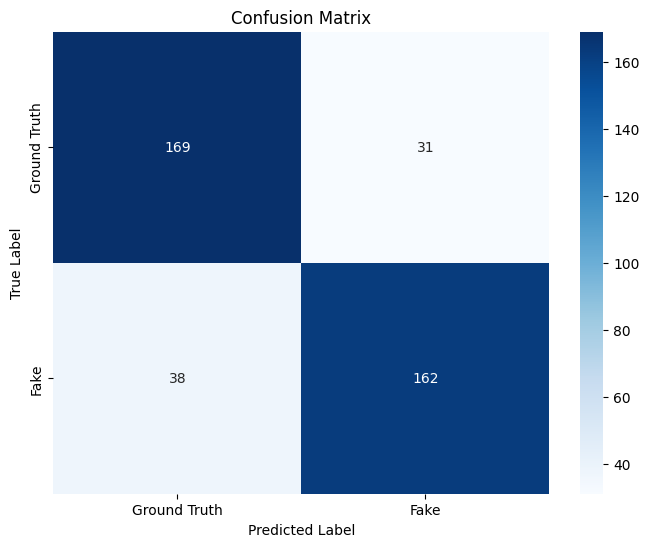

In [ ]:

import numpy as np
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load the saved features and labels
train_features = np.load(os.path.join(save_dir, 'train_features.npy'))
train_labels = np.load(os.path.join(save_dir, 'train_labels.npy'))
test_features = np.load(os.path.join(save_dir, 'test_features.npy'))
test_labels = np.load(os.path.join(save_dir, 'test_labels.npy'))

print("Loaded train and test data for classification.")
print(f"Train data shape: {train_features.shape}, {train_labels.shape}")
print(f"Test data shape: {test_features.shape}, {test_labels.shape}")

# Initialize the XGBoost classifier
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Train the classifier
print("Training XGBoost classifier...")
xgb_clf.fit(train_features, train_labels)
print("✅ XGBoost classifier trained.")

# Make predictions on the test set
print("Making predictions on the test set...")
test_predictions = xgb_clf.predict(test_features)
test_probabilities = xgb_clf.predict_proba(test_features)[:, 1] # Get probabilities for the positive class
print("✅ Predictions made.")

# Evaluate the classifier
accuracy = accuracy_score(test_labels, test_predictions)
roc_auc = roc_auc_score(test_labels, test_probabilities)
class_report = classification_report(test_labels, test_predictions)
conf_mat = confusion_matrix(test_labels, test_predictions)

print("\n--- XGBoost Classifier Evaluation ---")
print(f"Accuracy: {accuracy:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print("\nClassification Report:")
print(class_report)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['Ground Truth', 'Fake'], yticklabels=['Ground Truth', 'Fake'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

Loaded train and test data for classification.
Train data shape: (1600, 32), (1600,)
Test data shape: (400, 32), (400,)
Performing Grid Search...
Fitting 3 folds for each of 540 candidates, totalling 1620 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:56:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


✅ Grid Search completed.
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 150, 'subsample': 0.8}
Best ROC AUC Score on training set: 0.8943

--- Evaluation of Best XGBoost Model ---
Accuracy: 0.8500
ROC AUC: 0.9244

Classification Report:
              precision    recall  f1-score   support

         0.0       0.83      0.89      0.86       200
         1.0       0.88      0.81      0.84       200

    accuracy                           0.85       400
   macro avg       0.85      0.85      0.85       400
weighted avg       0.85      0.85      0.85       400



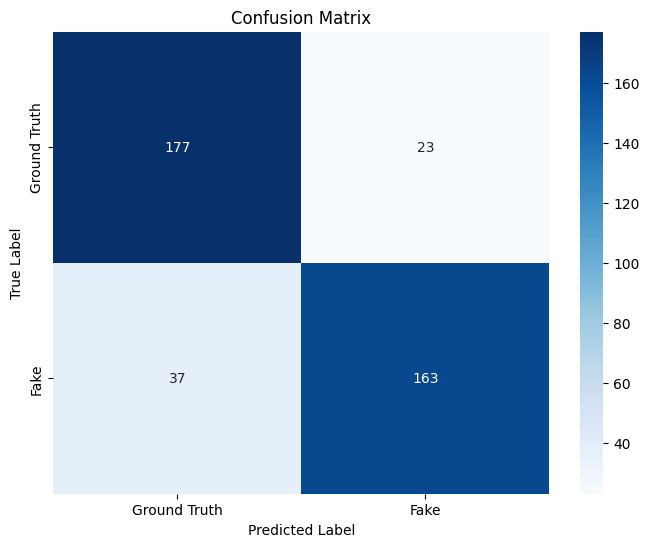

Best XGBoost model saved to /content/drive/MyDrive/IntroAIProject/smallsize_test/xgboost_best_model.pkl


In [ ]:
import numpy as np
import os
import joblib
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load the saved features and labels
train_features = np.load(os.path.join(save_dir, 'train_features.npy'))
train_labels = np.load(os.path.join(save_dir, 'train_labels.npy'))
test_features = np.load(os.path.join(save_dir, 'test_features.npy'))
test_labels = np.load(os.path.join(save_dir, 'test_labels.npy'))

print("Loaded train and test data for classification.")
print(f"Train data shape: {train_features.shape}, {train_labels.shape}")
print(f"Test data shape: {test_features.shape}, {test_labels.shape}")

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 120, 150],
    'max_depth': [4, 5, 6],
    'learning_rate': [0.02, 0.05, 0.1],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.8, 0.9]
}
# {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 150, 'subsample': 0.8}

# Initialize the classifier
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Perform Grid Search
print("Performing Grid Search...")
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=3,  # 3-fold cross-validation
    verbose=1,
    n_jobs=-1
)
grid_search.fit(train_features, train_labels)

print("✅ Grid Search completed.")
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best ROC AUC Score on training set: {grid_search.best_score_:.4f}")

# Use the best model to make predictions
best_model = grid_search.best_estimator_
test_predictions = best_model.predict(test_features)
test_probabilities = best_model.predict_proba(test_features)[:, 1]

# Evaluate
accuracy = accuracy_score(test_labels, test_predictions)
roc_auc = roc_auc_score(test_labels, test_probabilities)
class_report = classification_report(test_labels, test_predictions)
conf_mat = confusion_matrix(test_labels, test_predictions)

print("\n--- Evaluation of Best XGBoost Model ---")
print(f"Accuracy: {accuracy:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print("\nClassification Report:")
print(class_report)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['Ground Truth', 'Fake'], yticklabels=['Ground Truth', 'Fake'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()




In [ ]:
# Save the best model
ckpt_path = '/content/drive/MyDrive/IntroAIProject'
model_save_path = os.path.join(ckpt_path, 'xgboost_best_model.pkl')
joblib.dump(best_model, model_save_path)
print(f"Trained XGBoost model saved to {model_save_path}")


Trained XGBoost model saved to /content/drive/MyDrive/IntroAIProject/xgboost_best_model.pkl


# INFER

In [ ]:
import numpy as np
import librosa
import torch
import os
from sklearn.preprocessing import normalize
import random
from tqdm import tqdm
import torchaudio


In [ ]:
frame_length=0.025
frame_shift=0.010
sample_rate=24000
n_lfcc=20

def pre_emphasis(signal, coeff=0.97):
    return np.append(signal[0], signal[1:] - coeff * signal[:-1])

def peak_normalize(signal):
    return signal / np.max(np.abs(signal))

def add_noise(signal, noise_level=0.005):
    noise = np.random.normal(0, noise_level, signal.shape)
    return signal + noise

def chunk_signal(signal, sr, frame_length=frame_length, frame_shift=frame_shift):
    frame_len = int(frame_length * sr)
    hop_len = int(frame_shift * sr)
    frames = librosa.util.frame(signal, frame_length=frame_len, hop_length=hop_len).T
    return frames

lfcc_transform = torchaudio.transforms.LFCC(
    sample_rate=sample_rate,
    n_lfcc=n_lfcc,
    speckwargs={"n_fft": 1048, "hop_length": int(sample_rate * frame_length) + 1, "win_length": int(sample_rate * frame_length)},
    log_lf=True
)

def extract_lfcc(frame, sr = 24000):
    waveform = torch.tensor(frame).float().unsqueeze(0)
    lfcc = lfcc_transform(waveform)
    return lfcc.squeeze(0).T.numpy()


In [ ]:
def extract_gmm_scores(file_path, gmms, sr=24000):

    y, sr = librosa.load(file_path, sr=sr)
    y = peak_normalize(pre_emphasis(y))
    y = add_noise(y, noise_level=0.005)
    frames = chunk_signal(y, sr)

    gmm_scores = {}
    for gmm_name in GMMs.keys():
        gmm_scores[gmm_name] = []

    for frame in frames:
        if np.any(frame):
            for gmm_name, gmm in gmms.items():
                lfcc = extract_lfcc(frame, sr)
                logL = gmm.score_samples(lfcc)
                gmm_scores[gmm_name].append(logL)
    feature = []
    for gmm_name in GMMs.keys():
        scores = gmm_scores[gmm_name]
        feature.extend([
            np.mean(scores),
            np.std(scores),
            skew(scores)[0],
            kurtosis(scores)[0],
            np.min(scores),
            np.max(scores),
            np.percentile(scores, 25),
            np.percentile(scores, 75)
        ])

    return np.array(feature)

In [ ]:
def infer_voice_type(wave_path):
    """
    Infers whether a given audio file is ground truth or fake using the trained XGBoost model.

    Args:
        wave_path (str): The file path to the input WAV audio file.

    Returns:
        str: "Ground Truth" if the model predicts 0, "Fake" if the model predicts 1.
             Returns "Error processing file" if feature extraction fails.
    """

    GMMs = {
        "groundtruth": joblib.load("/content/drive/MyDrive/IntroAIProject/model/gmm_model_ground-truth.pkl"),
        "autoregressive": joblib.load("/content/drive/MyDrive/IntroAIProject/model/gmm_model_autoregressive.pkl"),
        "gan-based": joblib.load("/content/drive/MyDrive/IntroAIProject/model/gmm_model_gan-based.pkl"),
        "diffusion-based": joblib.load("/content/drive/MyDrive/IntroAIProject/model/gmm_model_diffusion-based.pkl"),
    }

    model_path = '/content/drive/MyDrive/IntroAIProject/model/xgboost_best_model.pkl'

    try:
        # Check if the model file exists
        if not os.path.exists(model_path):
            return f"Error: Model file not found at {model_path}"

        loaded_model = joblib.load(model_path)

        # Extract features from the input wave file
        features = extract_gmm_scores(wave_path, GMMs)

        # The model expects a 2D array (even for a single sample)
        features = features.reshape(1, -1)

        # Make prediction
        prediction = loaded_model.predict(features)[0]

        # Interpret the prediction
        if prediction == 0:
            return "Ground Truth"
        else:
            return "Fake"

    except Exception as e:
        print(f"An error occurred during inference: {e}")
        return "Error processing file"

# Example usage:
# Create a dummy wave file for testing
# dummy_audio_data = np.random.randn(24000 * 5).astype(np.float32) # 5 seconds of random audio
# dummy_wave_path = '/content/LibriSeVoc/LibriSeVoc-1k/gt/test/1737_142397_000031_000002.wav'
# sf.write(dummy_wave_path, dummy_audio_data, 24000)

# print(f"Testing inference on dummy file: {dummy_wave_path}")
# result = infer_voice_type(dummy_wave_path)
# print(f"Inference result: {result}")

# You would replace dummy_wave_path with the actual path to the wave file you want to classify.
# For example:
actual_wave_path = '/content/LibriSeVoc/LibriSeVoc-1k/gt/test/3830_12529_000013_000004.wav'
result = infer_voice_type(actual_wave_path)
print(f"Inference result for {actual_wave_path}: {result}")

# Clean up the dummy file
# os.remove(dummy_wave_path)


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator GaussianMixture from version 1.2.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Inference result for /content/LibriSeVoc/LibriSeVoc-1k/gt/test/3830_12529_000013_000004.wav: Ground Truth
